# Sentiment Analysis

Library Import

In [218]:
import numpy as np
import pandas as pd
import nltk
import string
import numbers
import seaborn as sns
from nltk.stem import WordNetLemmatizer
from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt
from wordcloud import WordCloud
from nltk.corpus import stopwords
from sklearn.metrics import f1_score, roc_auc_score

In [166]:
dataset_path = "Tweets.csv"
twitter_sentiment_analysis_df = pd.read_csv(dataset_path)
twitter_sentiment_analysis_df.head(5)

,tweet_id,airline_sentiment,airline_sentiment_confidence,negativereason,negativereason_confidence,airline,airline_sentiment_gold,name,negativereason_gold,retweet_count,text,tweet_coord,tweet_created,tweet_location,user_timezone
0,570306133677760513,neutral,1.0000,NaN,NaN,Virgin America,NaN,cairdin,NaN,0,@VirginAmerica What @dhepburn said.,NaN,2015-02-24 11:35:52 -0800,NaN,Eastern Time (US & Canada)
1,570301130888122368,positive,0.3486,NaN,0.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica plus you've added commercials t...,NaN,2015-02-24 11:15:59 -0800,NaN,Pacific Time (US & Canada)
2,570301083672813571,neutral,0.6837,NaN,NaN,Virgin America,NaN,yvonnalynn,NaN,0,@VirginAmerica I didn't today... Must mean I n...,NaN,2015-02-24 11:15:48 -0800,Lets Play,Central Time (US & Canada)
3,570301031407624196,negative,1.0000,Bad Flight,0.7033,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica it's really aggressive to blast...,NaN,2015-02-24 11:15:36 -0800,NaN,Pacific Time (US & Canada)
4,570300817074462722,negative,1.0000,Can't Tell,1.0000,Virgin America,NaN,jnardino,NaN,0,@VirginAmerica and it's a really big bad thing...,NaN,2015-02-24 11:14:45 -0800,NaN,Pacific Time (US & Canada)


In [167]:
text_field = "text"
airline_sentiment_field = "airline_sentiment"

In [168]:
twitter_sentiment_analysis_required_fields_df = twitter_sentiment_analysis_df[[text_field, airline_sentiment_field]]
twitter_sentiment_analysis_required_fields_df

,text,airline_sentiment
0,@VirginAmerica What @dhepburn said.,neutral
1,@VirginAmerica plus you've added commercials t...,positive
2,@VirginAmerica I didn't today... Must mean I n...,neutral
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
...,...,...
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative
14637,@AmericanAir Please bring American Airlines to...,neutral
14638,"@AmericanAir you have my money, you change my ...",negative


## Data Visualization

See class distributions

<AxesSubplot:xlabel='airline_sentiment', ylabel='Count'>

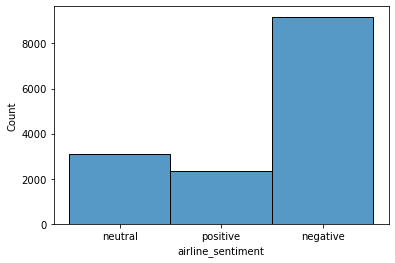

In [169]:
sns.histplot(twitter_sentiment_analysis_required_fields_df[airline_sentiment_field])

Word Count

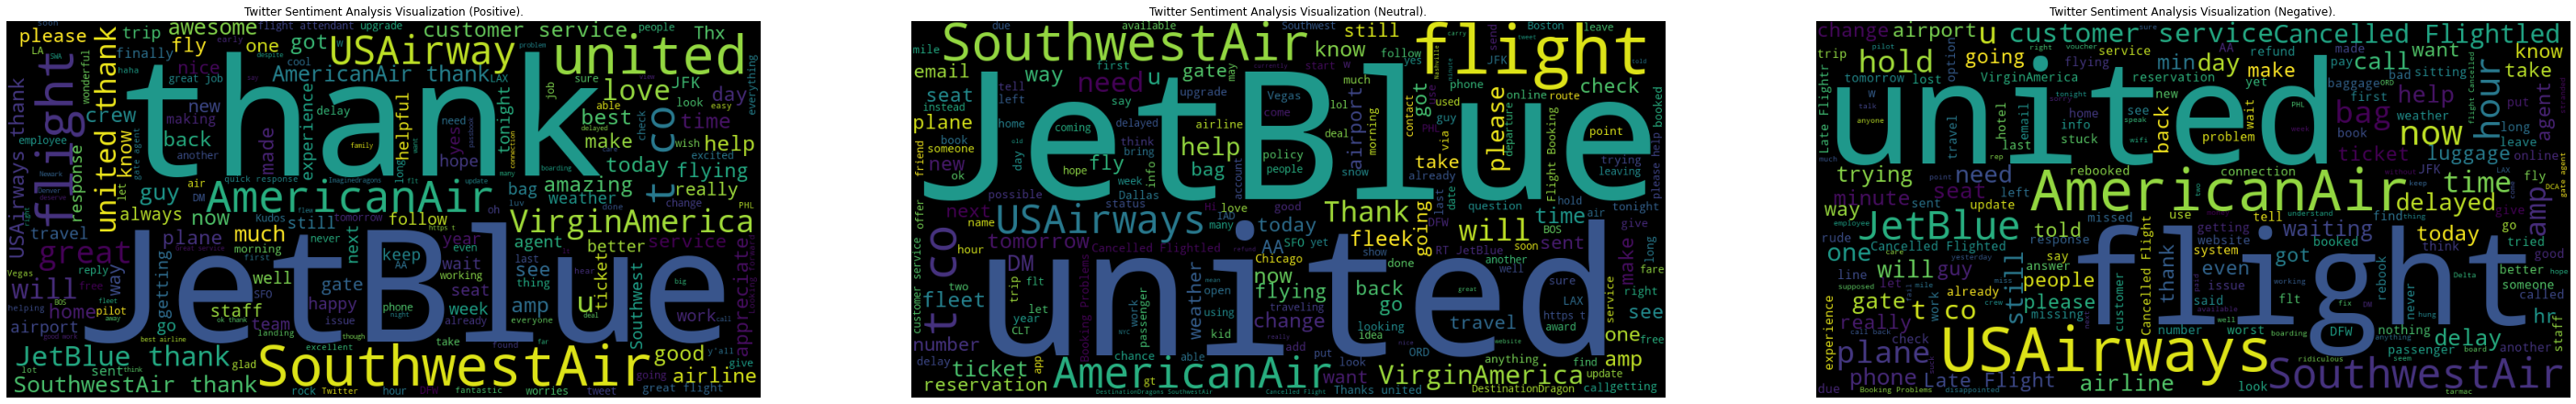

In [170]:
def visualize_word_cloud(documents, title, width, height):
    word_cloud = WordCloud(width = width, height = height, random_state = 100)
    text_from_all_documents = " ".join(documents)
    word_cloud.generate(text_from_all_documents)

    plt.title(title)
    plt.axis("off")
    plt.imshow(word_cloud)

plt.figure(figsize = (50, 20))
plt.subplot(1, 3, 1)
visualize_word_cloud(
    twitter_sentiment_analysis_required_fields_df[twitter_sentiment_analysis_required_fields_df[airline_sentiment_field].str.contains("positive")][text_field], 
    "Twitter Sentiment Analysis Visualization (Positive).", 
    1000,
    500
)
plt.subplot(1, 3, 2)
visualize_word_cloud(
    twitter_sentiment_analysis_required_fields_df[twitter_sentiment_analysis_required_fields_df[airline_sentiment_field].str.contains("neutral")][text_field], 
    "Twitter Sentiment Analysis Visualization (Neutral).", 
    1000,
    500
)
plt.subplot(1, 3, 3)
visualize_word_cloud(
    twitter_sentiment_analysis_required_fields_df[twitter_sentiment_analysis_required_fields_df[airline_sentiment_field].str.contains("negative")][text_field], 
    "Twitter Sentiment Analysis Visualization (Negative).", 
    1000,
    500
)
plt.show()

## Data Preprocessing

Erase Neutral Labels

In [171]:
twitter_sentiment_analysis_required_fields_df = twitter_sentiment_analysis_required_fields_df[~(twitter_sentiment_analysis_required_fields_df[airline_sentiment_field].str.contains("neutral"))]
twitter_sentiment_analysis_required_fields_df

,text,airline_sentiment
1,@VirginAmerica plus you've added commercials t...,positive
3,@VirginAmerica it's really aggressive to blast...,negative
4,@VirginAmerica and it's a really big bad thing...,negative
5,@VirginAmerica seriously would pay $30 a fligh...,negative
6,"@VirginAmerica yes, nearly every time I fly VX...",positive
...,...,...
14633,@AmericanAir my flight was Cancelled Flightled...,negative
14634,@AmericanAir right on cue with the delays👌,negative
14635,@AmericanAir thank you we got on a different f...,positive
14636,@AmericanAir leaving over 20 minutes Late Flig...,negative


In [172]:
text_df = twitter_sentiment_analysis_required_fields_df[text_field]
sentiment_df = twitter_sentiment_analysis_required_fields_df[airline_sentiment_field]

Remove Tags

In [173]:
def remove_word_in_sentence_with_tags(text, tag_to_remove):
    removed_tags_text = [word for word in text.split(" ") if tag_to_remove not in word]
    removed_tags_text = " ".join(removed_tags_text)
    return removed_tags_text

text_removed_tags_df = [remove_word_in_sentence_with_tags(text, "@") for text in text_df]
text_removed_tags_df = [remove_word_in_sentence_with_tags(text, "#") for text in text_removed_tags_df]
text_removed_tags_df = [remove_word_in_sentence_with_tags(text, "https://") for text in text_removed_tags_df]
text_removed_tags_df[:10]

["plus you've added commercials to the experience... tacky.",
 'it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "and it's a really big bad thing about it",
 "seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying VA",
 'yes, nearly every time I fly VX this “ear worm” won’t go away :)',
 "Well, I didn't…but NOW I DO! :-D",
 "it was amazing, and arrived an hour early. You're too good to me.",
 'I &lt;3 pretty graphics. so much better than minimal iconography. :D',
 "This is such a great deal! Already thinking about my 2nd trip to &amp; I haven't even gone on my 1st trip yet! ;p",
 "I'm flying your skies again! U take all the away from travel http://t.co/ahlXHhKiyn"]

Lowercase All Letters

In [174]:
def lowercase_letters(sentence):
    return sentence.lower()

text_lowercase_df = list(map(lowercase_letters, text_removed_tags_df))
text_lowercase_df[:5]

["plus you've added commercials to the experience... tacky.",
 'it\'s really aggressive to blast obnoxious "entertainment" in your guests\' faces &amp; they have little recourse',
 "and it's a really big bad thing about it",
 "seriously would pay $30 a flight for seats that didn't have this playing.\nit's really the only bad thing about flying va",
 'yes, nearly every time i fly vx this “ear worm” won’t go away :)']

Remove all punctuations.

In [175]:
def get_removed_duplicated_space_in_string(my_string):
    return " ".join(my_string.split())

def get_erased_punctuations(text):
    list_of_punctuations = string.punctuation + '"‘'
    final_text = text
    
    for punc in list_of_punctuations:
        final_text = final_text.replace(punc, "")
    
    final_text = get_removed_duplicated_space_in_string(final_text)
    
    return final_text

text_no_punc_df = [get_erased_punctuations(text) for text in text_lowercase_df]
text_no_punc_df[:3]

['plus youve added commercials to the experience tacky',
 'its really aggressive to blast obnoxious entertainment in your guests faces amp they have little recourse',
 'and its a really big bad thing about it']

Remove Stopwords

In [176]:
nltk.download("stopwords")

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [177]:
my_stopwords = stopwords.words("english")
my_stopwords.append("Jetblue")
my_stopwords.append("AmericanAir")
my_stopwords.append("SouthwestAir")
my_stopwords.append("USAirways")

print(my_stopwords)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

Train Test Split

In [210]:
x_train, x_test, y_train, y_test = train_test_split(
    text_no_punc_df,
    sentiment_df,
    test_size = 0.13,
    random_state = 100
)

x_train = np.array(x_train)
x_test = np.array(x_test)
y_train = np.array(y_train)
y_test = np.array(y_test)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

print(x_train)
print(y_train)

(10040,)
(10040,)
(1501,)
(1501,)
['thanks but i didnt want to see weve started your flight search over or the fare amp rules for this itinerary has changed again'
 'please give tara g a pat on the back and praise she was very very helpful she is at phl member lounge'
 'hey why automated call me and then hang up at 445 am and why cant i reschedule cancelled flighted flights via web come on'
 ...
 'comin in clutch and sending me to charlotte then home i h8 u except for wayne u a real g'
 '122322 of unusable funds will not book with you again'
 'you just dont get it its not about the money its about people how about a public apology from the president of jet blue']
['negative' 'positive' 'negative' ... 'negative' 'negative' 'negative']


Label Encoder

In [211]:
label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_test_encoded = label_encoder.transform(y_test)

TF-IDF Vectorizer

In [212]:
tf_idf_vectorizer = TfidfVectorizer(max_features=3000)
train_vector_components = tf_idf_vectorizer.fit_transform(x_train.tolist())
test_vector_components = tf_idf_vectorizer.transform(x_test.tolist())

Apply Logistic Regression Model

In [213]:
# logistic_regression = LogisticRegression(solver = "liblinear")
logistic_regression = LogisticRegression()

logistic_regression.fit(train_vector_components, y_train_encoded)
train_predictions = logistic_regression.predict(train_vector_components)
test_predictions = logistic_regression.predict(test_vector_components)

print(train_predictions)
print(test_predictions)

[0 0 0 ... 0 0 0]
[0 1 0 ... 0 1 1]


## Data Evaluation

Accuracy Score

In [214]:
print(f"Train Score: {logistic_regression.score(train_vector_components, y_train_encoded)}")
print(f"Test Score: {logistic_regression.score(test_vector_components, y_test_encoded)}")

Train Score: 0.925597609561753
Test Score: 0.9153897401732178


F1-Score

In [217]:
print(f"Train F1-Score: {f1_score(train_predictions, y_train_encoded)}")
print(f"Test F1-Score: {f1_score(test_predictions, y_test_encoded)}")

Train F1-Score: 0.7854064923872451
Test F1-Score: 0.7608286252354048


AUC

In [220]:
print(f"AUC Train: {roc_auc_score(train_predictions, y_train_encoded)}")
print(f"AUC Test: {roc_auc_score(test_predictions, y_test_encoded)}")

AUC Train: 0.9365746514220891
AUC Test: 0.9291473478552474
